# Encoder Only

https://github.com/neelnanda-io/TransformerLens/blob/main/demos/BERT.ipynb

In [4]:
import torch, transformer_lens, itertools
from measureLM import visualizing, decoding, patching, scoring

from transformers import AutoTokenizer
from transformer_lens import HookedEncoder

In [8]:
model = HookedEncoder.from_pretrained("bert-base-cased").to("cpu")
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model.cfg.spacing = ""
model.tokenizer = tokenizer

If using BERT for interpretability research, keep in mind that BERT has some significant architectural differences to GPT. For example, LayerNorms are applied *after* the attention and MLP components, meaning that the last LayerNorm in a block cannot be folded.


Moving model to device:  mps
Loaded pretrained model bert-base-cased into HookedTransformer
Moving model to device:  cpu


### 1) Get activations


prompt 0
layer 11: [(0.0009, 'bad'), (0.0001, 'awful'), (0.5, '0'), (0.25, '1'), (0.0006, 'excellent')]


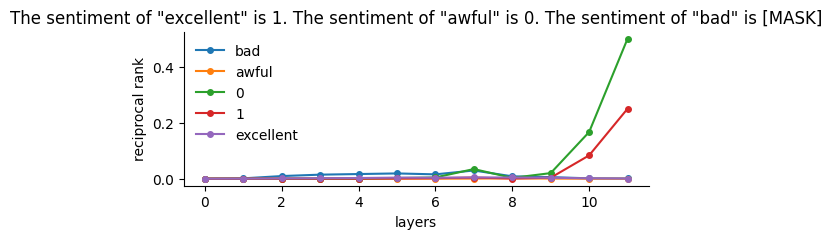

In [18]:
args = [("excellent","1"), ("awful","0"), ("bad","0")]
prompts = [f'The sentiment of "{args[0][0]}" is {args[0][1]}. The sentiment of "{args[1][0]}" is {args[1][1]}. The sentiment of "{args[2][0]}" is [MASK]']

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)

token_candidates = list(set(itertools.chain(*args)))
tok_idx = scoring.token_select(tokens, model, select_token="[MASK]")
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['.', ';', '!']
patching blocks.8.hook_mlp_out <-- blocks.8.hook_mlp_out
patching blocks.9.hook_mlp_out <-- blocks.9.hook_mlp_out
patching blocks.10.hook_mlp_out <-- blocks.10.hook_mlp_out
patching blocks.11.hook_mlp_out <-- blocks.11.hook_mlp_out

prompt 0
layer 11: [(0.0345, 'bad'), (0.001, 'awful'), (0.0025, '0'), (0.0031, '1'), (0.0009, 'excellent')]


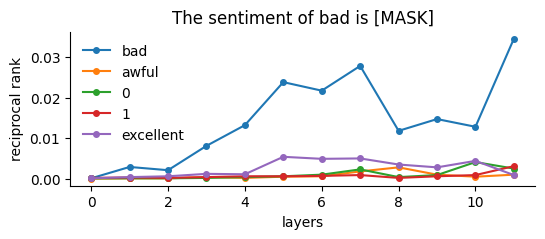

In [20]:
new_prompts = [f'The sentiment of {args[2][0]} is [MASK]']
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
insert_tok_idx = scoring.token_select(new_tokens, model, select_token="[MASK]")
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[insert_tok_idx], k=3).indices.tolist()[0])
print(pred)


patch_map = patching.create_hook_mapping(model, patch_l=(8, 15))
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=tok_idx, insert_tok_idx=insert_tok_idx)
resid_layer_scores = decoding.early_decoding(resid_post, model)

new_token_candidates = token_candidates

## scoring
extract_tok_idx = scoring.token_select(new_tokens, model, select_token="[MASK]")
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, extract_tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
